In [1]:
import networkx as nx
import numpy as np
from sklearn.cluster import KMeans
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from src.helper import draw_spring, load_graph_from_json
np.random.seed(123)

# 4 Community Detection

The detection of communities can bring structure in the network, making the results easier to interpret. In a court decisions citation network, for instance, one rather inspects 35 communities than 2,500 nodes. Ideally, the communities are substantively meaningful, meaning that the court decisions within a community have properties in common that they do not, or to a lesser extent, share with court decisions outside of that community. For instance, court decisions in a specific community in a given network might share that they are about causality, or about traffic accidents, whereas other communities might be about other legal or factual topics. This way, community detection can reveal groups of decisions that concern certain topics, facts, or are otherwise related based on citation patterns.

Community detection methods exist that automatically assign nodes to communities. Below, we give insight into how community detection works. 

## 4.1  Spectral Clustering

In the karate club example, we were interested in whether we could identify two groups: One that follows the president, and one that follows the trainer. One way to cluster networks into communities is to use KMeans on something that represents the action that is going on in the network. The K in KMeans stands for the number of clusters one wants to obtain. We start with two communities. 

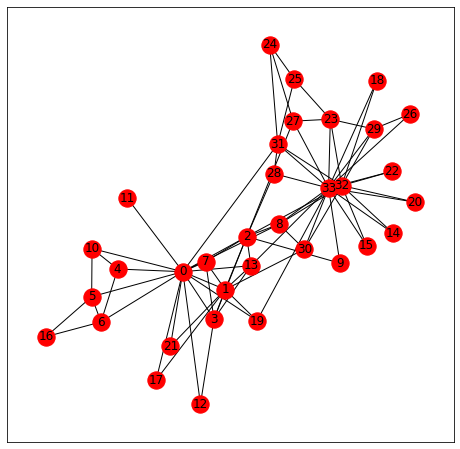

In [2]:
g_karate = nx.karate_club_graph()
draw_spring(g_karate, node_color="red")

How to obtain these two clusters with KMeans clustering? This can be done if the network is represented in mathematical form. The steps are easy to follow even if their inner workings are mysterious. 

Let us begin by introducing two matrices that encode information of the network: the degree matrix and the adjacency matrix. The degree matrix records the degree (number of edges) of every node. It does so in the diagonal. 

Below we have, let's say, four court decisions. The first one has a degree of two, the second and third a degree of 3, and the fourth a degree of 2.

$$ D = \pmatrix{
2 & 0 & 0 & 0 \\ 
0 & 3 & 0 & 0 \\ 
0 & 0 & 3 & 0 \\ 
0 & 0 & 0 & 2 \\ 
} $$

The adjacency matrix, by contrast, records the edges between the nodes. So a 1 here means a citation (from one case to another) and a 0 none (this was explained in more detail in section 3.3). 

$$ A = \pmatrix{
0 & 1 & 1 & 0 \\ 
1 & 0 & 1 & 1 \\ 
1 & 1 & 0 & 1 \\ 
0 & 1 & 1 & 0 \\ 
} $$

Using these two matrices we can find the Graph Laplacian matrix by simply subtracting the adjacency matrix from the degree matrix, so 

$$ L = D-A $$

Substraction of matrices is basic arithmetic, it just means elementwise substractions, so we do (for the first row:) 2-0, 0-1, 0-1, 0-0, and so forth until we get:

$$ L = \pmatrix{
2 & -1 & -1 & 0 \\ 
-1 & 3 & -1 & -1 \\ 
-1 & -1 & 3 & -1 \\ 
0 & -1 & -1 & 2 \\ 
} $$

Naturally the arithmetic involved in this will be practically impossible for humans on any matrix of reasonable size. Software can just give you the Laplacian matrix of a graph on command.

Below we show part of such matrix for the karate club example. As you can see, even for a small graph the matrix is unwieldy.

In [3]:
laplacian_karate = nx.laplacian_matrix(g_karate)
pd.DataFrame(laplacian_karate.todense()).head()

<class 'networkx.utils.decorators.argmap'> compilation 12:4: FutureWarning: laplacian_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.


,0,1,2,3,4,5,6,7,8,9,...,24,25,26,27,28,29,30,31,32,33
0,42,-4,-5,-3,-3,-3,-3,-2,-2,0,...,0,0,0,0,0,0,0,-2,0,0
1,-4,29,-6,-3,0,0,0,-4,0,0,...,0,0,0,0,0,0,-2,0,0,0
2,-5,-6,33,-3,0,0,0,-4,-5,-1,...,0,0,0,-2,-2,0,0,0,-2,0
3,-3,-3,-3,18,0,0,0,-3,0,0,...,0,0,0,0,0,0,0,0,0,0
4,-3,0,0,0,8,0,-2,0,0,0,...,0,0,0,0,0,0,0,0,0,0


The next step is to find the eigenvector associated with the smallest non-zero eigenvalues. As a rule of thumb, how many eigenvectors you want depends on how many clusters you want. If you want two clusters, you need to look for the smallest eigenvector. If you want three clusters, you select the two smallest, and so on.

Let us print a list of eigenvalues (obtained with Numpy, a package available in Python). As you will see the smallest value is 2.394 at position 22 (note that we start counting at 0, not 1).

In [11]:
# this get us the values and the vectors
vals, vecs = np.linalg.eig(laplacian_karate.todense())
# here we extract the values
vals

array([ 5.20653410e+01,  4.59907681e+01,  4.18328632e+01,  3.79927558e+01,
        2.96883840e+01,  2.55555039e+01,  2.27849630e+01,  2.13586504e+01,
        1.93238240e+01,  1.70337951e+01,  1.48885752e+01,  1.43813508e+01,
        1.20754027e+01,  1.18744202e+01, -2.37228377e-15,  1.02218147e+01,
        1.00106981e+01,  9.18096651e+00,  1.18710730e+00,  6.97788032e+00,
        6.44605541e+00,  5.59481244e+00,  2.39431926e+00,  5.16855490e+00,
        4.97817925e+00,  4.69727550e+00,  4.54469763e+00,  4.16160574e+00,
        3.70606484e+00,  3.80094429e+00,  2.93182048e+00,  2.96830180e+00,
        3.12126310e+00,  3.06104079e+00])

We can get the eigenvectors in position 10, that is, those associated with the smallest non-zero eigenvalue. Note that there are 34 of them, one for each node in the Karate club network example.

In [23]:
vals[18]

1.1871073019962068

array([-2.37228377e-15,  1.18710730e+00,  2.39431926e+00,  2.93182048e+00,
        2.96830180e+00,  3.06104079e+00,  3.12126310e+00,  3.70606484e+00,
        3.80094429e+00,  4.16160574e+00,  4.54469763e+00,  4.69727550e+00,
        4.97817925e+00,  5.16855490e+00,  5.59481244e+00,  6.44605541e+00,
        6.97788032e+00,  9.18096651e+00,  1.00106981e+01,  1.02218147e+01,
        1.18744202e+01,  1.20754027e+01,  1.43813508e+01,  1.48885752e+01,
        1.70337951e+01,  1.93238240e+01,  2.13586504e+01,  2.27849630e+01,
        2.55555039e+01,  2.96883840e+01,  3.79927558e+01,  4.18328632e+01,
        4.59907681e+01,  5.20653410e+01])

In [24]:
X = vecs[:,18]
X

matrix([[ 0.1233171 ],
        [ 0.0580066 ],
        [ 0.01368446],
        [ 0.07445083],
        [ 0.26733837],
        [ 0.29881441],
        [ 0.29744558],
        [ 0.06406144],
        [-0.0530052 ],
        [-0.12925543],
        [ 0.28550172],
        [ 0.20406685],
        [ 0.12324309],
        [ 0.03493189],
        [-0.17156602],
        [-0.15520216],
        [ 0.37166422],
        [ 0.16804128],
        [-0.21148231],
        [ 0.0625882 ],
        [-0.18847412],
        [ 0.1289233 ],
        [-0.16858175],
        [-0.14801794],
        [-0.15762212],
        [-0.14632034],
        [-0.19249255],
        [-0.12982346],
        [-0.09449019],
        [-0.16960883],
        [-0.08368282],
        [-0.1170647 ],
        [-0.13538405],
        [-0.12400534]])

Having this, we can cluster them using KMeans. In our case, we select two clusters.

In [25]:
from sklearn.cluster import KMeans
km = KMeans(2)
results = km.fit_predict(X)
for i in range(0,2):
    print(f"nodes for cluster {i}", np.where(results == i),"\n")

nodes for cluster 0 (array([ 8,  9, 14, 15, 18, 20, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32,
       33], dtype=int64),) 

nodes for cluster 1 (array([ 0,  1,  2,  3,  4,  5,  6,  7, 10, 11, 12, 13, 16, 17, 19, 21],
      dtype=int64),) 



D:\Anaconda3\envs\Gus_1\lib\site-packages\sklearn\utils\validation.py:727: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(
D:\Anaconda3\envs\Gus_1\lib\site-packages\sklearn\cluster\_kmeans.py:1332: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


And here we can see the results of the clustering.

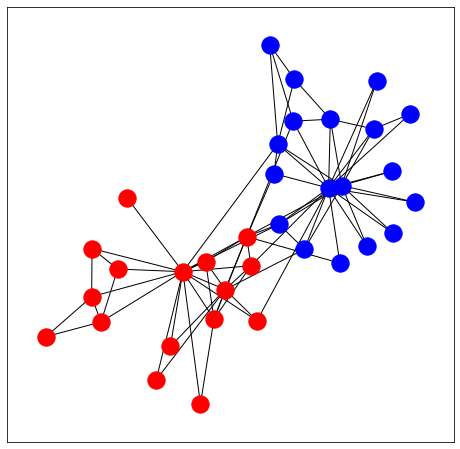

In [27]:
plt.figure(figsize=(8,8))
pos = nx.spring_layout(g_karate, seed =123)
nx.draw_networkx_nodes(g_karate, pos=pos, nodelist=[ 8,  9, 14, 15, 18, 20, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32,
       33], node_color="blue")
nx.draw_networkx_nodes(g_karate, pos=pos, nodelist=[0,  1,  2,  3,  4,  5,  6,  7, 10, 11, 12, 13, 16, 17, 19, 21], node_color="red")
nx.draw_networkx_edges(g_karate, pos=pos)

## 4.2 Louvain Communities

The Louvain method for community detection is an algorithm that finds communities by using the concept of modularity gain. 

To get into this, we first have to understand the concept of modularity.

### A. Modularity

Modularity in essence does two things:
1. It compares the edges of nodes in a certain community to the edges the nodes have to nodes outside of the community. Court decisions on contract law are more likely to cite one another (edges within the community) than to cite court decisions on human rights (edges outside of the community). The edges within the community can be compared to the edges outside of the community. The higher the number of edges within the community relative to the edges with nodes outside of the community, the higher the modularity.
2. It takes into consideration the number of edges in the network. The higher the number of edges in the network, the less important the difference becomes between the edges within the community and the edges to nodes outside of the community. This prevents small yet dense communities obtaining the highest modularity score and makes it more likely that larger denser communities (with more edges) will receive a high modularity score.

Both considerations are reflected in the formula for modularity, For ease of presentation, we will only consider modularity for undirected networks.

The formula for modularity can be presented in a variety of ways and there are advantages to each form or presentation. Here are two formulas:

$$ Q = \frac{1}{2m}\sum_{c=1}^{n} \left[ \Sigma A_c - \gamma\frac{\Sigma D_c^2}{2m} \right] $$


$$ Q = \sum_{c=1}^{n} \left[ \frac{\Sigma A_c}{2m} - \gamma\left( \frac{\Sigma D_c}{2m} \right) ^2 \right] $$

(These formulas have been adapted from the documentation to make the notation easier to follow, especially for an attempt to put them in practice by hand.)

For our discussion we will focus on the second formula, because it most clearly shows a difference between two ratios. The representation we choose here provides the most insight into what modularity does. 

* $ \Sigma A_c $ is the sum of the adjacency matrix of the community only (no edges to nodes outside of the community) .

* $ m $ is the total number of edges of the network.

* $\Sigma D_c$ is the degree of the nodes of the community, taking into consideration their edges to nodes outside of the community.

* $\gamma$ is a dampening parameter, that for our purposes can be ignored if set to 1. Making this number smaller will make it easier to find communities, and making it larger makes communities harder to find. (!!CHECK!!)

We observe a difference between fractions. That is to say, a difference between proportions.

* $ \frac{\Sigma A_c}{2m} $ represents the proportion of purely intra-community edges for a given community to the total number of edges. The division by 2 considers the fact that the adjacency matrix will count two for every edge.

* $ \left( \frac{\Sigma D_c}{2m} \right) ^2 $ represents the proportion of the edges that a community has to nodes within and outside of itself to the total number of edges in the network.

The logic of this is that if the left hand side of the difference is greater than the right hand side of the difference one will get a positive number. And the larger the difference, the tighter a community is, the larger the number. 

* The $ \Sigma $ is a summation notation that states that the difference between fractions will be repeated for every hypothesized community and added up. The higher the ultimate summation, the better the community partition is.

We can operationalize the formula "by hand" on the graph of Florentine families hypothesizing that the families Castellani, Peruzzi and Strozzi form a community vis-a-vis the rest of the other families. A quick look at the graphs suggest that this is a reasonable grouping.

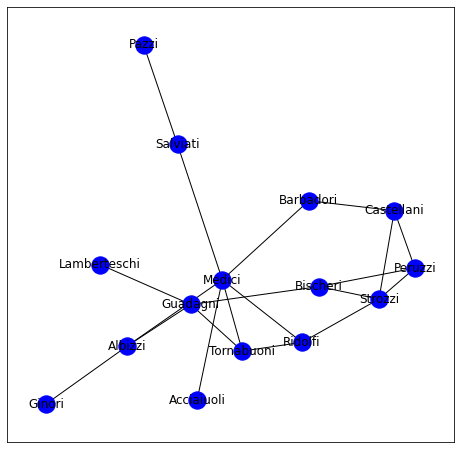

In [28]:
g_florentine = nx.florentine_families_graph()
draw_spring(g_florentine)

First let us save two lists with the names of the nodes that we want to use as hypothesized communities. Castellani, Peruzzi and Strozzi in one list, the rest on the other.

In [30]:
fl_CPS = ['Castellani','Peruzzi','Strozzi']
fl_other= ['Acciaiuoli', 'Medici', 'Barbadori', 'Ridolfi', 'Tornabuoni', 'Albizzi', 'Salviati', 'Pazzi', 'Bischeri', 'Guadagni', 'Ginori', 'Lamberteschi']

Since m is just the number of edges we can obtain the number in this manner.

In [31]:
m = len(g_florentine.edges)
m

20

For $\Sigma A_c $ we need to get the adjacency matrix of just the nodes within the community. This means we need to sever the connection of the community with other nodes. We can get this with the subgraph function.

In [32]:
sub_fl_CPS = g_florentine.subgraph(fl_CPS)
sub_fl_other = g_florentine.subgraph(fl_other)

Now we can get the adjacency matrix of the subgraphs like this...

In [33]:
nx.adjacency_matrix(sub_fl_CPS).todense()

C:\Users\gustavo.arosemena\AppData\Local\Temp\ipykernel_27048\1760126056.py:1: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  nx.adjacency_matrix(sub_fl_CPS).todense()


matrix([[0, 1, 1],
        [1, 0, 1],
        [1, 1, 0]], dtype=int32)

Numpy can sum all the values of such matrices with a call to np.sum.

In [34]:
SA_cps = np.sum(nx.adjacency_matrix(sub_fl_CPS).todense())
SA_other = np.sum(nx.adjacency_matrix(sub_fl_other).todense())
print(f"the value of SigmaA_c for the CPS community is {SA_cps} and for the other is {SA_other}")

the value of SigmaA_c for the CPS community is 6 and for the other is 26


C:\Users\gustavo.arosemena\AppData\Local\Temp\ipykernel_27048\3820810424.py:1: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  SA_cps = np.sum(nx.adjacency_matrix(sub_fl_CPS).todense())
C:\Users\gustavo.arosemena\AppData\Local\Temp\ipykernel_27048\3820810424.py:2: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  SA_other = np.sum(nx.adjacency_matrix(sub_fl_other).todense())


This gets us all we need for the left hand side of the difference.

Now we move to work on the right side of the difference. The value of $ \Sigma D_c $ is the sum of the degree of the nodes that interest us, but not with their values cut off from the network -that is, not as subgraphs- but in their full values connected to the Florentine families network. 

In terms of code it can be slightly tricky to unpack these values. Below we use a np.sum over a list comprehension that produces the degree scores of only the nodes we need.

In [35]:
SD_cps = np.sum([x[1] for x in list(nx.degree(g_florentine, fl_CPS))])

SD_other = np.sum([x[1] for x in list(nx.degree(g_florentine, fl_other))])

print(f"the value of SigmaD_c for the CPS community is {SD_cps} and for the other is {SD_other}")

the value of SigmaD_c for the CPS community is 10 and for the other is 30


Now we are ready to fill in the blanks. Remember the formula is:

$$ Q = \sum_{c=1}^{n} \left[ \frac{\Sigma A_c}{2m} - \gamma\left( \frac{\Sigma D_c}{2m} \right) ^2 \right] $$

So for the first community we have

$$ CPS =\left[ \frac{6}{40} - \gamma\left( \frac{10}{40} \right) ^2 \right] = 0.875 $$

In [36]:
CPS_result = (SA_cps/(2*m)) - ((SD_cps/(2*m))**2)
CPS_result

0.0875

And for the second 

$$ other = \left[ \frac{26}{40} - \gamma\left( \frac{30}{40} \right) ^2 \right] = 0.875 $$

In [37]:
other_result = (SA_other/(2*m)) - ((SD_other/(2*m))**2)
other_result

0.08750000000000002

And adding them together we get 0.175

In [38]:
CPS_result + other_result

0.17500000000000002

 Which is the same as the official result.

Thus the following partition has the positive modularity score of 0.175.

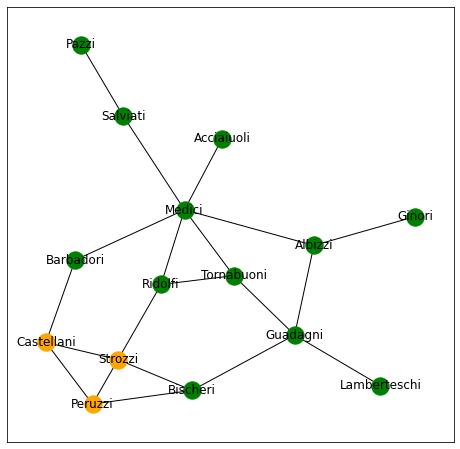

In [39]:
plt.figure(figsize=(8,8))
pos = nx.spring_layout(g_florentine)
nx.draw_networkx_nodes(g_florentine, pos, nodelist=fl_CPS, node_color='orange')
nx.draw_networkx_nodes(g_florentine, pos, nodelist=fl_other, node_color='green')
nx.draw_networkx_edges(g_florentine, pos=pos)
nx.draw_networkx_labels(g_florentine, pos=pos);

### B. Louvain Communities

What Louvain community detection does, is to try to find the distribution of communities that will give the highest modularity score, using a sort of cumulative random search.

1. It will asume every node is a community and score the modularity.
2. It will assign every node to a community with one of its neighbors and score the modularity of the result.
3. It will keep the assignment that gives the highest modularity score.
4. The resulting communities will be treated as nodes.
5. Step 1 is repeated.

This process keeps going until there is no more modularity gain.

We can quickly try to run the Louvain communities algorithm to find the best partition of the Florentine families network that we used earlier to discuss modularity.
It turns out the best split is in four communities. Compared to our intuitive results presented above, we can see that Castellani, Peruzzi and Strozzi did deserve to go together, but that Bischeri should have been also part their team.

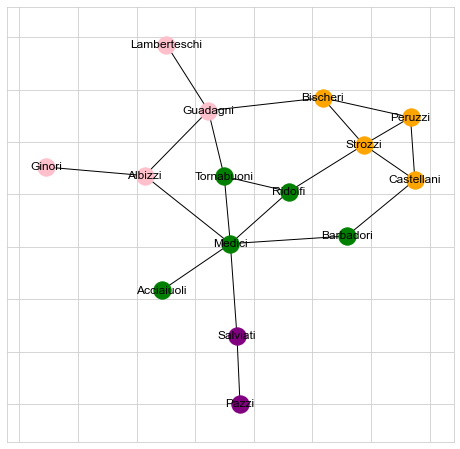

In [100]:
plt.figure(figsize=(8,8))
result = nx.algorithms.community.louvain_communities(g_florentine)
pos = nx.spring_layout(g_florentine)
nx.draw_networkx_nodes(g_florentine, pos, nodelist=result[0], node_color='orange')
nx.draw_networkx_nodes(g_florentine, pos, nodelist=result[1], node_color='green')
nx.draw_networkx_nodes(g_florentine, pos, nodelist=result[2], node_color='purple')
nx.draw_networkx_nodes(g_florentine, pos, nodelist=result[3], node_color='pink')
nx.draw_networkx_edges(g_florentine, pos=pos)
nx.draw_networkx_labels(g_florentine, pos=pos);

Now let us calculate the modularity score for the Louvain-detected communities. We can see that at 0.3975 it is quite a bit higher than our intuitive partition.

In [198]:
nx.algorithms.community.modularity(g_florentine, result)

0.3975

We now try to approximate this by hand. Let us see how far we can get. We will use a smaller graph, the kite, to make our life easier. There are key differences between what we are doing and the actual Louvain Communities algorithm. However, this will be enough for us to get an idea of what is going on.

The question is how to best partition the kite in terms of modularity.

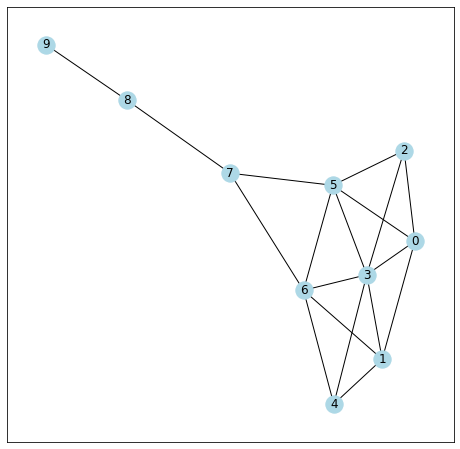

In [40]:
g_kite = nx.krackhardt_kite_graph()
draw_spring(g_kite, node_color="lightblue")

Doing a pseudo-Louvain process, We begin by assigning each node in the kite graph to its own community. Since this is a very bad partition, it makes sense that we get a negative modularity score.

In [200]:
nx.algorithms.community.modularity(g_kite, [[x] for x in range(0,10)])

-0.11574074074074076

Now we will assign each node, to one of its neighbors, and obtain the modularity score.

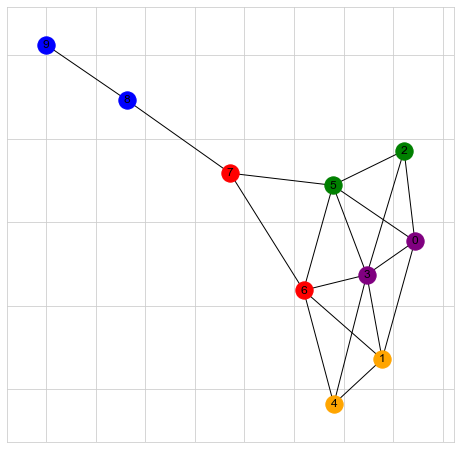

In [103]:
plt.figure(figsize=(8,8))
pos = nx.spring_layout(g_kite, seed=123)
nx.draw_networkx_nodes(g_kite, pos, nodelist=[9,8], node_color='blue')
nx.draw_networkx_nodes(g_kite, pos, nodelist=[7,6], node_color='red')
nx.draw_networkx_nodes(g_kite, pos, nodelist=[5,2], node_color='green')
nx.draw_networkx_nodes(g_kite, pos, nodelist=[4,1], node_color='orange')
nx.draw_networkx_nodes(g_kite, pos, nodelist=[3,0], node_color='purple')
nx.draw_networkx_edges(g_kite, pos=pos)
nx.draw_networkx_labels(g_kite, pos=pos);

In [202]:
nx.algorithms.community.modularity(g_kite, [[9,8], [7,6], [5,2],[4,1],[3,0]])

0.057098765432098755

Then we could keep assigning nodes and see an increase.

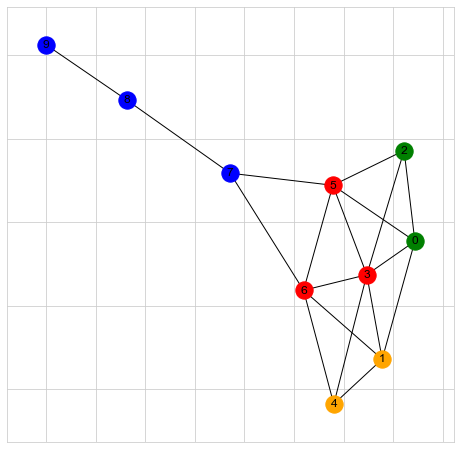

In [104]:
plt.figure(figsize=(8,8))
pos = nx.spring_layout(g_kite, seed=123)
nx.draw_networkx_nodes(g_kite, pos, nodelist=[9,8,7], node_color='blue')
nx.draw_networkx_nodes(g_kite, pos, nodelist=[6,5,3], node_color='red')
nx.draw_networkx_nodes(g_kite, pos, nodelist=[2,0], node_color='green')
nx.draw_networkx_nodes(g_kite, pos, nodelist=[4,1], node_color='orange')
nx.draw_networkx_edges(g_kite, pos=pos)
nx.draw_networkx_labels(g_kite, pos=pos);

In [204]:
nx.algorithms.community.modularity(g_kite, [[9,8,7], [6,5,3], [2,0],[4,1]])

0.08796296296296295

But not every reassignment is going to be an increase. If we extend the first cluster, we will get a decrease in modularity.

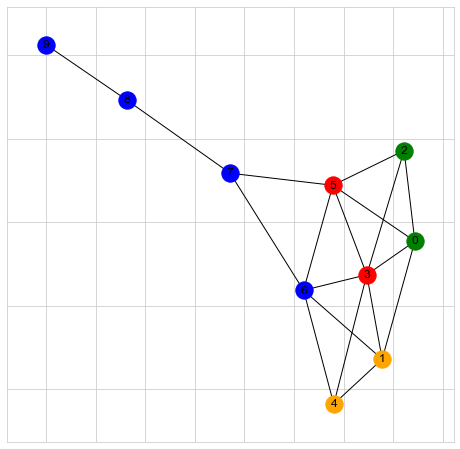

In [105]:
plt.figure(figsize=(8,8))
pos = nx.spring_layout(g_kite, seed=123)
nx.draw_networkx_nodes(g_kite, pos, nodelist=[9,8,7, 6], node_color='blue')
nx.draw_networkx_nodes(g_kite, pos, nodelist=[5,3], node_color='red')
nx.draw_networkx_nodes(g_kite, pos, nodelist=[2,0], node_color='green')
nx.draw_networkx_nodes(g_kite, pos, nodelist=[4,1], node_color='orange')
nx.draw_networkx_edges(g_kite, pos=pos)
nx.draw_networkx_labels(g_kite, pos=pos);

In [206]:
nx.algorithms.community.modularity(g_kite, [[9,8,7, 6], [5,3], [2,0],[4,1]])

0.07098765432098764

Our pseudo-Louvain algorithm would therefore stop short of that last assignment. The real Louvain method would do this in an mechanical, incremental fashion until the communities with very good modularity scores are found. The algorithm has elements of randomness, so it is not guaranteed to achieve the best result, or the same result every time it is run.

A difference of note is that instead of incrementally linking up the nodes of the kite, what are the communities at the first level will be turned into nodes at the second level. (!!add photo from louvain to leuven article!!). 

What this means in practice, is that unlike what we are doing, the algorithm does not focus on modularity per se, but on modularity gain. That is, it focuses on the difference in modularity between one partitioning and another. It does not really look for the highest modularity value, but instead keeps going while it finds positive modularity gain, or until modularity gains are so small that they fall below a specified margin.

Happily, the formula for modularity gain is not so different from that of modularity

$$ \Delta Q = \left[ \frac{\Sigma A_c + K_{in}}{2m} - \frac{\Sigma D_c + K_{in}}{2m} \right] - \left[\frac{\Sigma A_c}{2m}-\frac{\Sigma D_c}{2m} - \frac{K_in}{2m}  \right]   $$

In fact it is the ratio of two modulary scores. One (the left brackets) is the score with the node K inserted into it and the the other (the right bracket) is the score with the node K removed from it. It is added on the left and removed on the right to represent the delta, or the difference in modularity, when one community gains a node and another one loses it.

With our pseudo-Louvain approach we did not did do the best possible combination, but with the real Louvain communities algorithm we can see what the better partition would be:

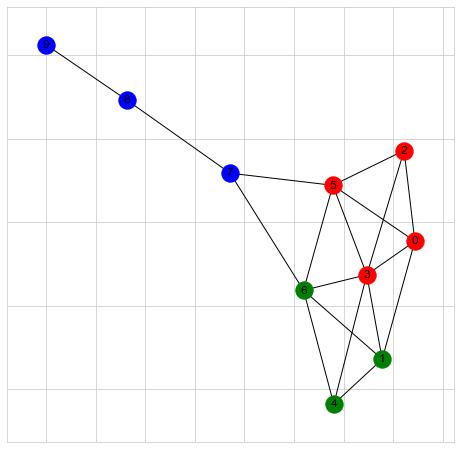

In [106]:
plt.figure(figsize=(8,8))
pos = nx.spring_layout(g_kite, seed=123)
result = nx.algorithms.community.louvain_communities(g_kite)
nx.draw_networkx_nodes(g_kite, pos, nodelist=result[0], node_color='red')
nx.draw_networkx_nodes(g_kite, pos, nodelist=result[1], node_color='green')
nx.draw_networkx_nodes(g_kite, pos, nodelist=result[2], node_color='blue')
nx.draw_networkx_edges(g_kite, pos=pos)
nx.draw_networkx_labels(g_kite, pos=pos);

We can do the same for the subgraph of the CJEU case law example. We first calculate the number of communities:

In [108]:
communities = sorted(nx.algorithms.community.greedy_modularity_communities(g_consprot2), key=len, reverse=True)
print(f"The network has {len(communities)} communities.")

The network has 13 communities.


We subsequently plot assign each node to a community and visualize the communities in the network.

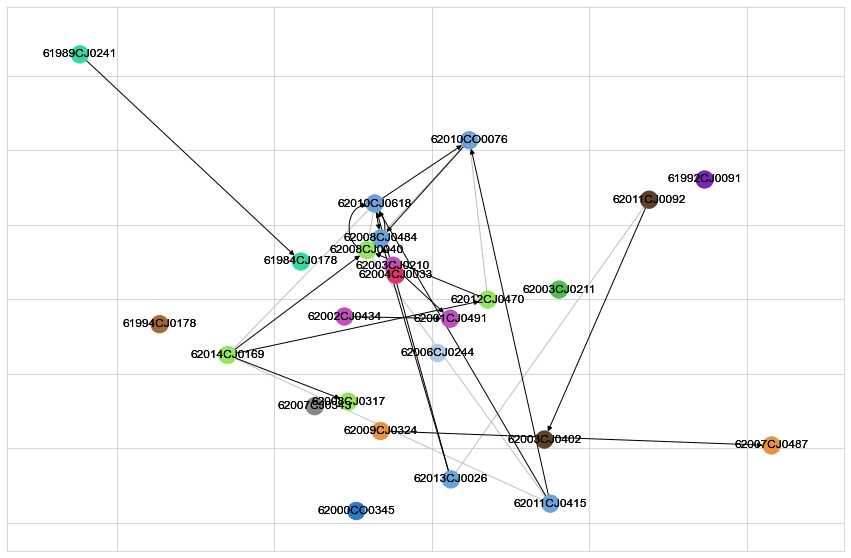

In [109]:

def set_node_community(G, communities):
    '''Add community to node attributes'''
    for c, v_c in enumerate(communities):
        for v in v_c:
            # Add 1 to save 0 for external edges
            G.nodes[v]['community'] = c + 1
def set_edge_community(G):
    '''Find internal edges and add their community to their attributes'''
    for v, w, in G.edges:
        if G.nodes[v]['community'] == G.nodes[w]['community']:
            # Internal edge, mark with community
            G.edges[v, w]['community'] = G.nodes[v]['community']
        else:
            # External edge, mark as 0
            G.edges[v, w]['community'] = 0
def get_color(i, r_off=1, g_off=1, b_off=1):
    '''Assign a color to a vertex.'''
    r0, g0, b0 = 0, 0, 0
    n = 16
    low, high = 0.1, 0.9
    span = high - low
    r = low + span * (((i + r_off) * 3) % n) / (n - 1)
    g = low + span * (((i + g_off) * 5) % n) / (n - 1)
    b = low + span * (((i + b_off) * 7) % n) / (n - 1)
    return (r, g, b)

# Set node and edge communities
set_node_community(g_consprot2, communities)
set_edge_community(g_consprot2)
node_color = [get_color(g_consprot2.nodes[v]['community']) for v in g_consprot2.nodes]
# Set community color for edges between members of the same community (internal) and intra-community edges (external)
external = [(v, w) for v, w in g_consprot2.edges if g_consprot2.edges[v, w]['community'] == 0]
internal = [(v, w) for v, w in g_consprot2.edges if g_consprot2.edges[v, w]['community'] > 0]
internal_color = ['black' for e in internal]

# Set node and edge communities
set_node_community(g_consprot2, communities)
set_edge_community(g_consprot2)
node_color = [get_color(g_consprot2.nodes[v]['community']) for v in g_consprot2.nodes]
# Set community color for edges between members of the same community (internal) and intra-community edges (external)
external = [(v, w) for v, w in g_consprot2.edges if g_consprot2.edges[v, w]['community'] == 0]
internal = [(v, w) for v, w in g_consprot2.edges if g_consprot2.edges[v, w]['community'] > 0]
internal_color = ['black' for e in internal]

g_consprot2_pos = nx.spring_layout(g_consprot)
plt.rcParams.update({'figure.figsize': (15, 10)})
# Draw external edges
nx.draw_networkx(
    g_consprot2,
    pos=g_consprot2_pos,
    node_size=0,
    edgelist=external,
    edge_color="silver")
# Draw nodes and internal edges
nx.draw_networkx(
    g_consprot2,
    pos=g_consprot2_pos,
    node_color=node_color,
    edgelist=internal,
    edge_color=internal_color)
plt.show()